This study investigates the effectiveness of **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** models in classifying **coding** and **non-coding** DNA sequences within a metagenomic dataset related to lettuce microbiome (Study MGYS00000513). The data included **gene features, DNA sequences**, and **labels** indicating coding (1) or non-coding (0) status. 

Given the potential imbalance between coding and non-coding sequences, the **Synthetic Minority Oversampling Technique (SMOTE)** was employed to balance the dataset before training the models. This approach achieved an accuracy of 91% in distinguishing between coding and non-coding sequences, suggesting the potential of GRU for analyzing metagenomic data.

## Used Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

2024-05-19 20:56:15.399126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 20:56:15.399225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 20:56:15.566210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import Data

In [2]:
df0 = pd.read_csv('/kaggle/input/coding-noncoding-dna-sequences/Coding_NonCoding_DNA_Sequences')
data_shuffled = df0.sample(frac=1, random_state=1)
data_shuffled.head(10)

,Unnamed: 0,gene_features,DNA_sequence,Target
60455,60455,MISEQ:128:000000000-A7920:1:2116:18663:4630_1:...,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,49650,MISEQ:128:000000000-A7920:1:2105:14571:1816_1:...,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,31043,MISEQ:128:000000000-A7920:1:1109:15231:15963_1...,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,42092,MISEQ:128:000000000-A7920:1:1117:15174:18638_1...,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,10200,MISEQ:128:000000000-A7920:1:1119:16225:2246_1:...,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1
8572,8572,MISEQ:128:000000000-A7920:1:1115:20973:18702_1...,CCCGGCCGGATGACGCACGGTTCGATTCCCGCATCGGTGCGCGAGC...,1
6384,6384,MISEQ:128:000000000-A7920:1:1112:14351:3335_1:...,CCCGGAACGGTGCGCGCAGGTCAATCATCGTTTAGCTTGGCTCGGT...,1
33505,33505,MISEQ:128:000000000-A7920:1:1111:7885:11265_1:...,ATACACGAGTCTGGACACAACTGCAATGCCAGCACAACCCCACGAA...,0
49120,49120,MISEQ:128:000000000-A7920:1:2104:18393:14064_1...,ATCCAACACCACCTCAAATCTGGTATTAAAACCAGCGTGATGACAG...,0
47404,47404,MISEQ:128:000000000-A7920:1:2103:9167:7933_1:N...,ATGCTTTCTTCATCACGTCCTCCAGGGGAAACCTCTGGCACACTAT...,0


In [3]:
data_shuffled.head()

,Unnamed: 0,gene_features,DNA_sequence,Target
60455,60455,MISEQ:128:000000000-A7920:1:2116:18663:4630_1:...,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,49650,MISEQ:128:000000000-A7920:1:2105:14571:1816_1:...,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,31043,MISEQ:128:000000000-A7920:1:1109:15231:15963_1...,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,42092,MISEQ:128:000000000-A7920:1:1117:15174:18638_1...,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,10200,MISEQ:128:000000000-A7920:1:1119:16225:2246_1:...,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1


## Basic EDA and Distribution

In [4]:
df = data_shuffled[['DNA_sequence', 'Target']]

In [5]:
df.head()

,DNA_sequence,Target
60455,GCTCACGCGCTTCAAGGCTGCTCACCGCGAGGAGCAGCTCGAGCCA...,0
49650,GAGCTCACCCGGGATGCCGAAGAACGGCGAGACCGGGCGGGCGTCG...,0
31043,CACCTGCCCGCTACTGACCGCTGGTGGACACCGAAACCGAATGGGG...,0
42092,GCTACGAACTGACCGAGCCGCCGGAACACCGCAATCTGGACCGCTT...,0
10200,GTCGCGCGCTGGAAGAACGGCGAGATCGTGGAGGAGAACCTGTTCT...,1


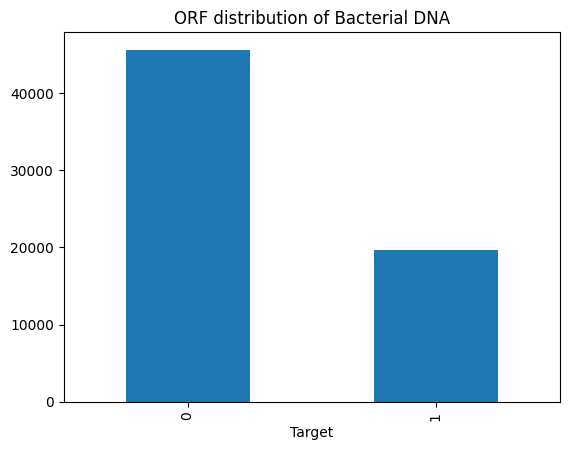

In [6]:
df['Target'].value_counts().sort_index().plot.bar()
plt.title("ORF distribution of Bacterial DNA");

In [7]:
def kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [8]:
df['DNA_sequence'] = df.apply(lambda x: kmers_funct(x['DNA_sequence']), axis=1)

/tmp/ipykernel_24/3880847245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DNA_sequence'] = df.apply(lambda x: kmers_funct(x['DNA_sequence']), axis=1)


In [9]:
df.head()

,DNA_sequence,Target
60455,"[gctcac, ctcacg, tcacgc, cacgcg, acgcgc, cgcgc...",0
49650,"[gagctc, agctca, gctcac, ctcacc, tcaccc, caccc...",0
31043,"[cacctg, acctgc, cctgcc, ctgccc, tgcccg, gcccg...",0
42092,"[gctacg, ctacga, tacgaa, acgaac, cgaact, gaact...",0
10200,"[gtcgcg, tcgcgc, cgcgcg, gcgcgc, cgcgct, gcgct...",1


## Determination of Variables

In [10]:
X = df['DNA_sequence'].values   
y = df['Target'].values

## Data Preprocessing 

In [11]:
tokenizer = Tokenizer(num_words=None)

In [12]:
tokenizer.fit_on_texts(X)

In [13]:
X_num_tokens = tokenizer.texts_to_sequences(X)

In [14]:
X_pad = pad_sequences(X_num_tokens, maxlen=1000)

In [15]:
X_pad.shape

(65321, 1000)

In [16]:
y.shape

(65321,)

## Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, 
                                                    y, 
                                                    test_size = 0.1,
                                                    stratify = y,
                                                    random_state=1)

## SMOTE

In [18]:
sm = SMOTE(random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [19]:
embedding_size = 100
num_words = 10000

## GRU

In [20]:
model = Sequential()
model.add(Embedding(input_dim=num_words,        
                    output_dim=embedding_size))    
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=48, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=24, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(units=12)))
model.add(Dense(1, activation='sigmoid'))

In [21]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stop = EarlyStopping(monitor="val_Recall", mode="max",         
                           verbose=1, patience = 20, restore_best_weights=True)

In [24]:
model_history = model.fit(X_train, y_train, epochs=50, batch_size=1024,
                          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 769ms/step - Recall: 0.6300 - loss: 0.6720 - val_Recall: 5.0710e-04 - val_loss: 0.6142
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 797ms/step - Recall: 0.5777 - loss: 0.4356 - val_Recall: 0.1937 - val_loss: 0.5756
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 808ms/step - Recall: 0.6804 - loss: 0.3983 - val_Recall: 0.0355 - val_loss: 0.5930
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 808ms/step - Recall: 0.6990 - loss: 0.3863 - val_Recall: 0.1886 - val_loss: 0.5772
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 807ms/step - Recall: 0.7200 - loss: 0.3761 - val_Recall: 0.0553 - val_loss: 0.6474
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 807ms/step - Recall: 0.7444 - loss: 0.3599 - val_Recall: 0.1263 - val_loss: 0.6114
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 809ms/step - Recall: 0.7687 - loss: 0.3422 - val_Recall: 0.3058 - val_loss: 0.6434
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 807ms/step - Recall: 0.8068 - loss: 0.3203 - val_Recall: 0.1856 - val_loss: 0.6

## GRU Model Evaluation

In [25]:
y_train_pred = model.predict(X_train) >= 0.5
print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

2566/2566 ━━━━━━━━━━━━━━━━━━━━ 150s 58ms/step
[[38008  3034]
 [ 6338 34704]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     41042
           1       0.92      0.85      0.88     41042

    accuracy                           0.89     82084
   macro avg       0.89      0.89      0.89     82084
weighted avg       0.89      0.89      0.89     82084



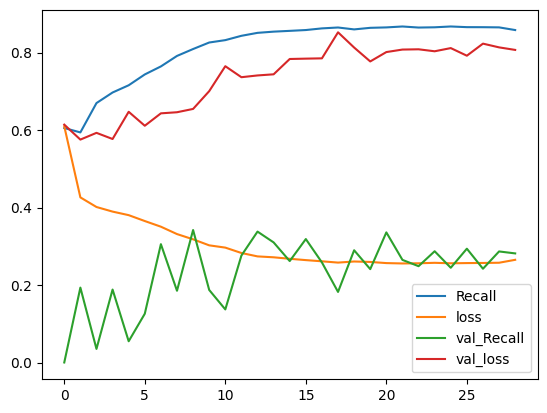

In [26]:
pd.DataFrame(model_history.history).plot();

## LSTM

In [27]:
model = Sequential()
model.add(Embedding(input_dim=num_words,        
                    output_dim=embedding_size))    
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=48, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=24, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dense(1, activation='sigmoid'))

In [28]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stop = EarlyStopping(monitor="val_Recall", mode="max",         
                           verbose=1, patience = 10, restore_best_weights=True)

In [31]:
model_history = model.fit(X_train, y_train, epochs=30, batch_size=1024,
                          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 814ms/step - Recall: 0.5768 - loss: 0.6589 - val_Recall: 0.0796 - val_loss: 0.6377
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 803ms/step - Recall: 0.5738 - loss: 0.5225 - val_Recall: 0.0152 - val_loss: 0.6169
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 802ms/step - Recall: 0.5726 - loss: 0.4392 - val_Recall: 0.0360 - val_loss: 0.6012
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 803ms/step - Recall: 0.5952 - loss: 0.4220 - val_Recall: 0.0527 - val_loss: 0.5911
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 803ms/step - Recall: 0.6405 - loss: 0.4081 - val_Recall: 0.0827 - val_loss: 0.5818
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 801ms/step - Recall: 0.6504 - loss: 0.4132 - val_Recall: 0.0507 - val_loss: 0.5889
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 802ms/step - Recall: 0.6535 - loss: 0.4032 - val_Recall: 0.3261 - val_loss: 0.5991
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 801ms/step - Recall: 0.7090 - loss: 0.3894 - val_Recall: 0.2252 - val_loss: 0.5851


## LSTM Model Evaluation

In [32]:
y_train_pred = model.predict(X_train) >= 0.5
print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

2566/2566 ━━━━━━━━━━━━━━━━━━━━ 149s 58ms/step
[[38065  2977]
 [ 4087 36955]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     41042
           1       0.93      0.90      0.91     41042

    accuracy                           0.91     82084
   macro avg       0.91      0.91      0.91     82084
weighted avg       0.91      0.91      0.91     82084



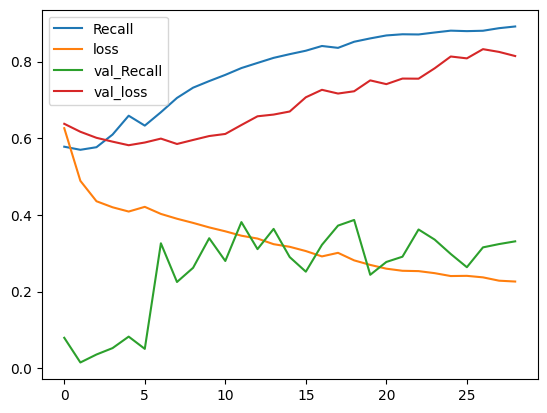

In [33]:
pd.DataFrame(model_history.history).plot();